# **Aula 2 - Bandido multi-armado e Exploração/Inspeção**

Bem-vindo ao notebook da nossa aula sobre o problema dos bandidos multi-armados com estratégias de exploração e inspeção.

Neste notebook vamos utilizar a [classe RL-Glue](https://sites.google.com/a/rl-community.org/rl-glue/Home/rl-glue) para implementar os experimentos do nosso curso. Ele foi originalmente desenvolvido por Adam White, Brian Tanner e Rich Sutton. Esta biblioteca nos dá estrutura para compreender como funciona a mecânica dos algoritmos de aprendizado por reforço e como executa-los, explora-los e modifica-los. 

Pode parecer um pouco confuso no início, entretanto tenha fé! 

Vamos orientar ao longo do notebook de forma cadenciada e apresentar outros elementos da área ao longo do nosso curso.

## **Seção 0: Preliminares**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

import rl_utils
from rl_utils import RLGlue

Na célula acima, importamos as bibliotecas que precisamos para este exercício. 

Você deve ter notado que importamos o arquivo multi_bandido_10. Este é o arquivo de testes com o cenário de bandidos com 10 braços apresentado na seção 2.3 do nosso [livro texto](https://www.amazon.com.br/Reinforcement-Learning-Introduction-Richard-Sutton/dp/0262039249). Vamos usar este caso em todo notebook para validar nossos experimentos. O nosso multi-bandido tem 10 braços, que são as ações que o agente poderá realizar a cada instante *time-step*. Ao puxar um braço, temos uma recompensa estocástica vindas de uma distribuição gaussiana com variância unitária. 

Para cada ação, o valor esperado dessa ação é amostrado aleatoriamente a partir da distribuição normal. Recomendamos a leitura do capítulo supracitado para um melhor entendimento dos conceitos explorados.

## **Seção 1 - Agente Guloso**

Estamos interessados em criar um agente que encontre a ação com maior recompensa esperada. Uma maneira de um agente operar é sempre escolher a ação com o valor mais alto com base nas estimativas atuais do agente. Olhando para seu histórico e escolhendo as ações que sabidamente são mais vantajosas. Chamamos isso de **agente guloso**, pois de forma *greedy*, ou gulosa, escolhe a ação que pensa ter o valor mais alto. Vejamos o que acontece neste caso.

Primeiro, vamos implementar a função argmax, que recebe uma lista de valores de ação e retorna uma ação, que tem o maior valor. Por que estamos realizando nossa própria implementação e não utilizando a função `argmax` do Numpy? Em caso de uma ou mais entradas com o mesmo valor, a função `argmax` do Numpy retorna a primeira ocorrência daquele valor. Não queremos manter este comportamento para não introduzir viéses em ações específicas. Em vez disso, vamos introduzir comportamentos randômicos no processo. 

Dessa forma, iremos implementar nossa própria função `argmax`. A função do Numpy [np.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) poderá ser util para o próximo exercício.

In [140]:
# TAREFA DE IMPLEMENTAÇÃO
np.random.seed(0)

def argmax(q_values):
    """
    Recebe uma lista de valores_q e retorna o do item que tem o maior 
    valor. A função trata empates aleatoriamente.     
    returns: int - o índice do maior valor em valores_q
    """
    top_value = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        # Se um valor em valores_q for maior que o maior valor corrente,
        # atualiza a variável top e zera a lista de empates. 
        # Se o valor é igual corrente for igual ao maior valor já encontrado,
        # adiciona o valor na lista empates. 
        # INÍCIO DO CÓDIGO
        if q_values[i] > top_value:
            top_value = q_values[i]
            ties = [i]
        elif q_values[i] == top_value:
            ties.append(i)
        # FIM DO CÓDIGO
    return np.random.choice(ties)

In [141]:
# Célula de teste.

# Semente fixa para resultados determinísticos.
np.random.seed(0)
test_array = [1, 0, 0, 1]

counts = [0, 0, 0, 0]
for _ in range(100):
    a = argmax(test_array)
    counts[a] += 1

# Garantir que argmax não retorna sempre a primeira entrada.
assert counts[0] != 100, "Garanta que sua implementação de argmax escolhe aleatoriamente entre os maiores valores."

# Garantir que argmax não retorna sempre a última entrada. 
assert counts[3] != 100, "Garanta que sua implementação de argmax escolhe aleatoriamente entre os maiores valores."

# Garantir que o gerador de números aleatórios é chamado exatamente quando argmax é invocado.
expected = [44, 0, 0, 56] # <-- notice not perfectly uniform due to randomness
assert counts == expected

Agora você implementará um agente utilizando como base a biblioteca RL-Glue.

Aqui, vamos criar um `GreedyAgent` e implementar o método `agent_step`. Este método é chamado sempre que o agente dá um passo. O método deve retornar a ação selecionada pelo agente. Este método também garante que as estimativas do agente sejam atualizadas com base nos sinais que recebe do ambiente.

Na célula abaixo implemente o agente guloso. Siga os comentários no código para facilitar o entendimento da lógica do agente.

In [142]:
# TAREFA DE IMPLEMENTAÇÃO
np.random.seed(0)

class GreedyAgent(rl_utils.Agent):
    def agent_step(self, reward, observation=None):
        """
        Implementa um passo do agente. Ele recebe uma recompensa e observação e
        retorna a ação que o agente escolhe no determinado passo de iteração.
        
        Arguments:
        recompensa -- float, a recompensa que o agente recebe do ambiente após ter tomado a última ação. 
        observacao -- float, o estado observado que o agente se encontra atualmente. 
                      Não se preocupe muito com isso neste momento, uma
                      vez que só utilizaremos este conceito nas próximas lições.
        Returns:
        current_action -- int, ação que escolhida pelo agente no passo de tempo atual.
        """
        ### Variáveis importantes na Classe Agente. ###
        # @self.q_values : Array com histórico de valores que o agente acredita ser verdade até o momento.
        # @self.arm_count : Array com um contador do número de vezes que a arma (alavanca) foi acionada.
        # @self.last_action : Ação que o agente tomou no passo anterior.
        #######################
        
        # Etapa 1 do algoritmo.
        # Dica de atualização dos valores-Q: Procure pelo algoritmo nas notas de aula ou na seção 2.4 do livro.
        # 1 - Incrementa o contador em @self.arm_count para a ação do passo anterior.
        # 2 - Atualiza @self.q_values para a ação do passo anterior.      
        # INÍCIO DO CÓDIGO
        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += ((reward - self.q_values[self.last_action])/self.arm_count[self.last_action])
        
        # FIM DO CÓDIGO
        
        # Etapa 2 do algoritmo.
        # Ação atual recebe o valor máximo utilizando a implementação de argmax previamente implementada.
        # INÍCIO DO CÓDIGO
        current_action = argmax(self.q_values)
        # FIM DO CÓDIGO
    
        self.last_action = current_action
        
        return current_action

In [143]:
# Célula de teste 1.
np.random.seed(1)

greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 1.0, 0, 0]
greedy_agent.arm_count = [0, 1, 0, 0, 0]
greedy_agent.last_action = 1
action = greedy_agent.agent_step(1, 0)
print(greedy_agent.q_values)
np.save("greedy_test", greedy_agent.q_values)
print("Resultado:")
print(greedy_agent.q_values)
print("Resultado Esperado:")
print([0, 0.5, 1.0, 0, 0])

assert action == 2, "Verifique que você está usando a função argmax para escolher a ação com o maior valor."
assert greedy_agent.q_values == [0, 0.5, 1.0, 0, 0], "Verifique se você está atualizando q_values corretamente."

[0, 0.5, 1.0, 0, 0]
Resultado:
[0, 0.5, 1.0, 0, 0]
Resultado Esperado:
[0, 0.5, 1.0, 0, 0]


In [144]:
# Célula de teste 2.

# Constrói um agente fake para testar algumas condições iniciais.
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 1.0, 0, 0]
greedy_agent.arm_count = [0, 1, 0, 0, 0]
greedy_agent.last_action = 1

# Realiza um passo no agente fake.
action = greedy_agent.agent_step(reward=1)

# Garantindo que o agente tomou uma decisão gulosa.
assert action == 2

# Garantindo que q_values estão sendo atualizados corretamente.
assert greedy_agent.q_values == [0, 0.5, 1.0, 0, 0]

# Realiza um novo passo.
action = greedy_agent.agent_step(reward=2)
assert action == 2
print(greedy_agent.q_values)
assert greedy_agent.q_values == [0, 0.5, 2.0, 0, 0]

[0, 0.5, 2.0, 0, 0]


Agora, vamos visualizar o resltado. 

Por enquanto estamos realizando os experimentos utilizando as implementações das interações do agente com o ambiente via `RL-Glue`. Será desta forma nesta aula, entretanto nas próximas aluas vamos trabalhar com ambientes customizados. Assim, você poderá experimentar e variar o ambiente de acordo.

100%|██████████| 200/200 [00:05<00:00, 35.35it/s]


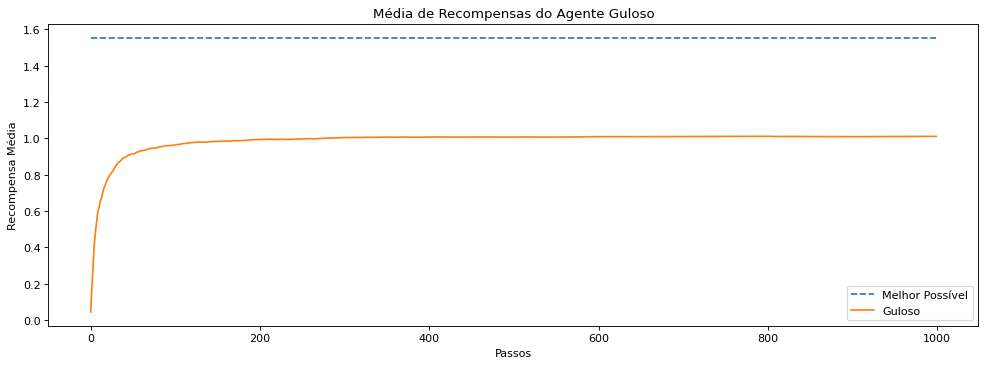

In [145]:

# Célula de discussão.

# Número de vezes que vamos executar o experimento.
num_runs = 200                    

# Número de vezes que vamos disparar os braços/armas do agente.
num_steps = 1000

# Setando o ambiente que vamos usar para teste.
env = rl_utils.Environment

# Escolhendo o agente que vamos utilizar.
agent = GreedyAgent

# Passamos para o agente as informações que eles precisam. Aqui, definimos quantos braços/armas ele tem.
agent_info = {"num_actions": 10}  

# Passamos ao ambiente a informação que ele precisa. Por hora, nada.
env_info = {}

all_averages = []

average_best = 0
# tqdm é utilizada para gerar a barra de progresso.
for run in tqdm(range(num_runs)):           
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)          
    rl_glue.rl_init(agent_info, env_info) 
    rl_glue.rl_start()                    

    average_best += np.max(rl_glue.environment.arms)
    
    scores = [0]
    averages = []
    
    for i in range(num_steps):
        # O ambiente e o agente executam um passo de iteração,
        # retornando a recompensa e a ação.
        reward, _, action, _ = rl_glue.rl_step()
                                                 
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([average_best / num_runs for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Melhor Possível", "Guloso"])
plt.title("Média de Recompensas do Agente Guloso")
plt.xlabel("Passos")
plt.ylabel("Recompensa Média")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)

E aí? Como foi o desempenho do nosso agente?
Será que conseguimos melhorar ainda mais seu desempenho?


## **Seção 2 - Agente Epsilon-Greedy**

Nas notas de aula aprendemos sobre uma outra maneira do agente operar, onde nem sempre ele realiza ações gulosas. Em vez disso, combinamos um componente de exploração em suas ações. Ele realiza este movimento para re-descobrir os melhores caminhos e confirmar que o histórico de ações que ele detém realmente é o melhor a se seguir. Mas note que ao longo do caminho ele poderá descobrir novas abordagens para lidar com o problema. Neste caso, ele passa a dar chance, de forma arbitrária, a novos caminhos (inspeção). 

Por agora, o melhor momento da implementação!

Implemente um agente epsilon-greedy. 

Dica importante: estamos implementando o algoritmo da seção 2.4 do livro. 

Dicas de funções úteis: [np.random.random](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.random.html) e [np.random.randint](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html).

In [159]:
# TAREFA DE IMPLEMENTAÇÃO
np.random.seed(0)

class EpsilonGreedyAgent(rl_utils.Agent):
    def agent_step(self, reward, observation):
        """
        Implementa um passo do agente. Ele recebe uma recompensa e observação e
        retorna a ação que o agente escolhe no determinado passo de iteração.
        
        Arguments:
        recompensa -- float, a recompensa que o agente recebe do ambiente após ter tomado a última ação. 
        observacao -- float, o estado observado que o agente se encontra atualmente. 
                      Não se preocupe muito com isso neste momento, uma
                      vez que só utilizaremos este conceito nas próximas lições.
        Returns:
        current_action -- int, ação que escolhida pelo agente no passo de tempo atual.
        """
        ### Variáveis importantes na Classe Agente. ###
        # @self.q_values : Array com histórico de valores que o agente acredita ser verdade até o momento.
        # @self.arm_count : Array com um contador do número de vezes que a arma (alavanca) foi acionada.
        # @self.last_action : Ação que o agente tomou no passo anterior.
        # @self.epsilon : Probabilidade epsilon que o agente irá explorar (range entre 0 e 1).
      
        # Etapa 1 do algoritmo.
        # Atualiza os valores Q. Está deve ser a operação realizada para o agente guloso.
        # INÍCIO DO CÓDIGO
        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += ((reward-self.q_values[self.last_action])/self.arm_count[self.last_action])
        # FIM DO CÓDIGO

        # Etapa 2 do algoritmo.
        # Realiza ação utilizando a abordagem epsilon-greedy.        
        # Escolhe aleatoriamente um número entre 0 e 1. Se esse número for menor que 
        # self.epsilon, atualiza current_action para ser uma decisão puramente aleatória.
        # Caso contrário, escolhe a ação baseada no maior valor de q.
        # INÍCIO DO CÓDIGO.
        rng = np.random.random()
        if rng < self.epsilon:
            current_action = np.random.choice(np.arange(len(self.arm_count)))
        else:
            current_action = argmax(self.q_values)
        
        self.last_action = current_action
        # FIM DO CÓDIGO.

        return current_action

In [160]:
# Nesta célula você pode alterar os valores das variáveis para validar sua implementação.
# Instancia um agente fale para testar e ajusta algumas condições iniciais.
np.random.seed(0)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0.0, 0.5, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5

# Dada a semente aleatória, deveríamos ver uma ação gulosa neste passo.
action = e_greedy_agent.agent_step(reward=1, observation=0)

# Garantir de atualizar "last_action", não o estado atual.
assert e_greedy_agent.q_values != [0, 0.5, 1.0, 0, 0], "A"

# Garantir que stepsize é baseado em "last_action" e não no estado atual.
assert e_greedy_agent.q_values != [0, 1, 0.5, 0, 0], "B"

# Garantir que o agente está utilizando "argmax", que implementa o desempate.
assert action == 2, "C"

# ______________________________________ #

# Vamos ver o que acontece em outra ação. 
np.random.seed(1)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0.5, 0.5, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5

# Dada a semente aleatória acima, deveriamos ver uma ação aleatória (ação 4) aqui.
action = e_greedy_agent.agent_step(reward=1, observation=0)

# O agente recebeu uma recompensa com valor 1, então, 
# devemos incrementar os valores para "last_action".
assert e_greedy_agent.q_values == [0, 0.75, 0.5, 0, 0], "D"

# O agente deve escolher uma ação aleatória para esta específica semente.
assert action == 4, "E"

Nosso agente epsilon-greedy foi criado e testado com sucesso (esperamos!).

Vamos comparar um agente epsilon-greedy de 10% exploratório com um agente puramente guloso. 

100%|██████████| 200/200 [00:07<00:00, 26.94it/s]


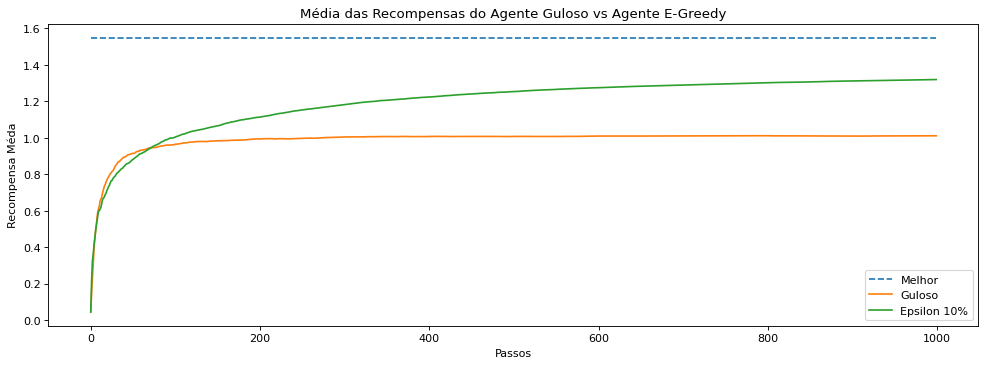

In [161]:
# Imprime os resultados para epsilon-greedy x agente guloso.
num_runs = 200
num_steps = 1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env = rl_utils.Environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
env_info = {}
all_averages = []

for run in tqdm(range(num_runs)):
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    averages = []
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.title("Média das Recompensas do Agente Guloso vs Agente E-Greedy")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(("Melhor", "Guloso", "Epsilon 10%"))
plt.xlabel("Passos")
plt.ylabel("Recompensa Méda")
plt.show()

Note como o agente epsilon-greedy se sai melhor, sobretudo no longo prazo!

Para um número de passos em torno 20~30, o agente guloso acaba performando melhor (curto prazo). Mas a medida que o tempo passa, o agente epsilon-greedy dispara na frente com maiores recompensas. Isso ocorre pois o componente exploratório contribui para a definições de novos caminhos até então não descobertos pelo agente.

Quando agimos somente de forma gulosa, corremos o risco de escolher soluções sub-ótimas.

## **Seção 2.1 - Média de Múltiplas Execuções**

Você percebeu que realizamos a média de mais de 200 execuções? 
Por que fizemos desta forma?

Vamos explorar o ambiente sem as médias para uma avaliação.

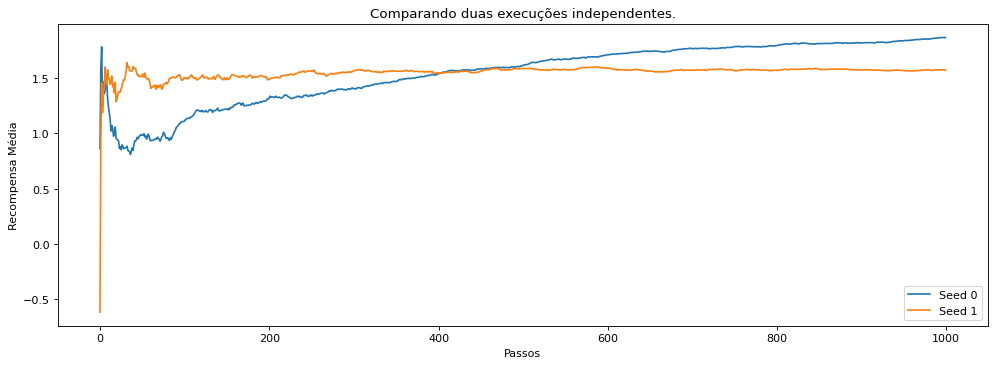

In [165]:
agent = EpsilonGreedyAgent
env = rl_utils.Environment
agent_info = {"num_actions": 10, "epsilon": 0.1}
env_info = {}
all_averages = []
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
num_steps = 1000

for run in (0, 1):
    # Vamos fixar a semente para que possamos comparar diferentes execuções.
    np.random.seed(run) 
    averages = []
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    for i in range(num_steps):
        reward, state, action, is_terminal = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    
    plt.plot(averages, label="Seed {}".format(run))

plt.title("Comparando duas execuções independentes.")
plt.legend()
plt.xlabel("Passos")
plt.ylabel("Recompensa Média")
plt.show()

Note como as execuções são diferentes! Mas por que? Se estamos executando duas vezes o mesmo algoritmo, por que ele se comportaria de maneira diferente nas duas execuções?

Isso se deve à aleatoriedade do ambiente do agente!

Dependendo da ação que agente escolhe aleatoriamente no começo, ou quando decide de forma randômica explorar, ele poderá adotar diferentes caminhos, se comparado com outros agentes. E mesmo que as ações sejam as mesmas, como nossa recompensa é amostrada de uma gaussiana, os valores finais divergem. 

O agente pode ter sorte e ver recompensas maiores pela melhor ação no início e, assim, decidir pela melhor ação mais rapidamente. Ou pode ter azar e ver recompensas menores pela melhor ação no início e, portanto, demorar mais para reconhecer que é de fato a melhor ação.

Para ser mais concreto, vejamos quantas vezes uma ação exploratória é realizada para diferentes sementes.

In [181]:
print("Semente Aleatória 1")
np.random.seed(0)
for _ in range(10):
    if np.random.random() < 0.1: print("Ação Exploratória.")

print()
print()

print("Semente Aleatória 2")
np.random.seed(1)
for _ in range(10):
    if np.random.random() < 0.1: print("Ação Exploratória.")

Semente Aleatória 1


Semente Aleatória 2
Ação Exploratória.
Ação Exploratória.


Notamos que com a primeira semente não realizamos nenhuma ação exploratória em 10 execuções. Em contrapartida, para a segunda semente realizamos duas ações aleatórias para o mesmo número de passos. Consegue visualizar que isto pode alterar de maneira consistente o desempenho do algoritmo?

É muito comum, portanto, reportarmos o desempenho de algoritmos de aprendizado em termos dos valores finais médios de várias execuções. Isso ameniza o efeito *estocástico* do algoritmo, nos fornecendo *insights* mais significativos. 



## **Seção 3 - Comparando valores de Epsilon**

Agora, como será o comportamento do algoritmo se variarmos o nosso epsilon? 

Será que podemos considerar este parâmetro do algoritmo um *hyper-parâmetro*, como nos algoritmos de Machine Learning? Discutam com os colegas de turma!

Vamos realizar alguns experimentos e verificar o comportamento do epsilon. Exploraremos diferentes condições iniciais para entender o desempenho do algortimo para estas várias versões de ambiente.

100%|██████████| 200/200 [00:07<00:00, 26.41it/s]


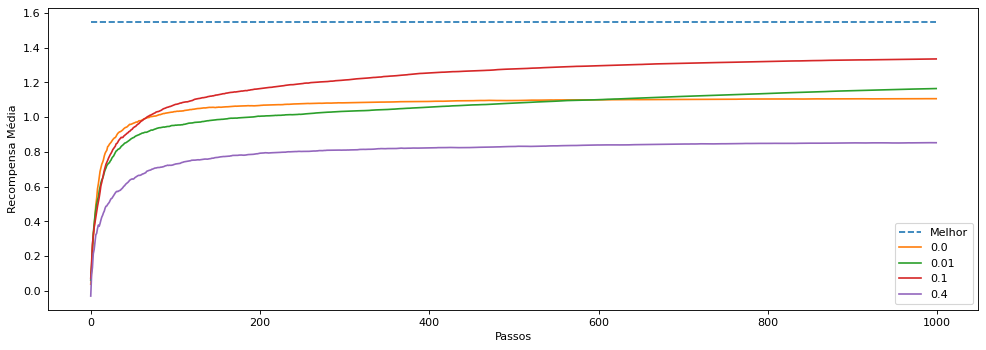

In [182]:
# Diferentes valores do epsilon.
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 200

for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        best_action_chosen = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))

plt.legend(["Melhor"] + epsilons)
plt.xlabel("Passos")
plt.ylabel("Recompensa Média")
plt.show()

Por que 10% teve um desempenho melhor do que 1%?

Se explorar é realmente bom, por que exploração de 40% teve desempenho pior que o agente guloso (0%)?

Pense nas razões para discutirmos durante a aula.

R: No caso do epsilon = 1% o agente não conseguiu explorar o ambiente o bastante para encontrar o braço que dá maior retorno no longo prazo. Já no caso do epsilon = 40% o agente tomava muitas decisões sem tomar em conta o que já sabia sobre o ambiente, portanto mesmo que tenha conseguido encontrar o braço com maior retorno, não teve confiança nessa decisão e por isso demorou muito para conseguir aproveitar o retorno do melhor braço.

## **Seção 4 - O Efeito do *step-size***

Na Seção 1, decaímos o tamanho do passo ao longo do tempo, com base nas contagens da seleção da ação. O tamanho do passo foi 1/N(A), onde N(A) é o número de vezes que a ação A foi selecionada. 

Isso é o mesmo que calcular uma média de amostra. Também podemos definir o tamanho do passo como um valor constante, como 0.1. Qual seria o efeito de fazer isso? E é melhor usar uma constante ou a média das amostra?

Para investigar esta questão, vamos começar criando um novo agente que tem um tamanho de passo constante. Use como base as implementações anteriores. 

Altere a atualização para ter um step-size constante em vez de usar a atualização 1/N(A).

In [209]:
# TAREFA DE IMPLEMENTAÇÃO
class EpsilonGreedyAgentConstantStepsize(rl_utils.Agent):
    def agent_step(self, reward, observation):
        """
        Implementa um passo do agente. Ele recebe uma recompensa e observação e
        retorna a ação que o agente escolhe no determinado passo de iteração.
        
        Arguments:
        recompensa -- float, a recompensa que o agente recebe do ambiente após ter tomado a última ação. 
        observacao -- float, o estado observado que o agente se encontra atualmente. 
                      Não se preocupe muito com isso neste momento, uma
                      vez que só utilizaremos este conceito nas próximas lições.
        Returns:
        current_action -- int, ação que escolhida pelo agente no passo de tempo atual.
        """
        ### Variáveis importantes na Classe Agente. ###
        # @self.q_values : Array com histórico de valores que o agente acredita ser verdade até o momento.
        # @self.arm_count : Array com um contador do número de vezes que a arma (alavanca) foi acionada.
        # @self.last_action : Ação que o agente tomou no passo anterior.
        # @self.step_size : Valor numérico com o step-size atual do agente.
        # @self.epsilon : Probabilidade epsilon que o agente irá explorar (range entre 0 e 1).
        #######################
        
        # Etapa 1 do algoritmo.
        # Atualização dos valores q_values para ação tomada no passo anterior.
        # Use self.step_size no lugar de self.arm_count
        
        # INÍCIO DO CÓDIGO
        
        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += ((reward-self.q_values[self.last_action])*self.step_size)
        # FIM DO CÓDIGO
        
        # Etapa 2 do algoritmo.
        # Implementação E-Greedy, como feito na implementação acima.
        # INÍCIO DO CÓDIGO
        rng = np.random.random()
        if rng < self.epsilon:
            current_action = np.random.choice(np.arange(len(self.arm_count)))
        else:
            current_action = argmax(self.q_values)
        
        self.last_action = current_action
        # FIM DO CÓDIGO

        return current_action

In [210]:
# Célula de testes.
# Altere os valores para validar sua implementação.
np.random.seed(0)
for step_size in [0.01, 0.1, 0.5, 1.0]:
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize()
    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size
    action = e_greedy_agent.agent_step(1, 0)
    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0], "Verifique que você está atualizando q_values corretamente utilizando a variável @self.step_size."

100%|██████████| 200/200 [00:07<00:00, 28.44it/s]
<ipython-input-211-dc858510db13>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


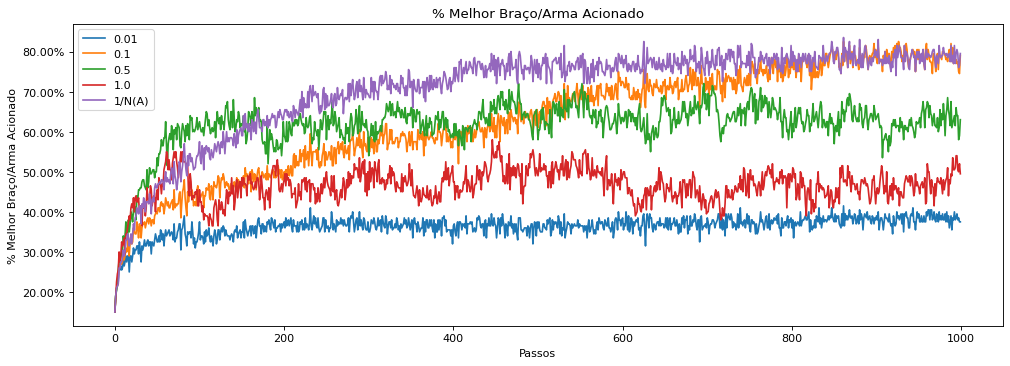

In [211]:
# Experimento para diferentes step-sizes.
step_sizes = [0.01, 0.1, 0.5, 1.0, '1/N(A)']

epsilon = 0.1
num_steps = 1000
num_runs = 200

fig, ax = plt.subplots(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        np.random.seed(run)
        agent = EpsilonGreedyAgentConstantStepsize if step_size != '1/N(A)' else EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}
        env_info = {}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        
        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)
            
        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size], axis=0))

plt.legend(step_sizes)
plt.title("% Melhor Braço/Arma Acionado")
plt.xlabel("Passos")
plt.ylabel("% Melhor Braço/Arma Acionado")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

Note que agora estamos plotando o percentual das vezes que o melhor braço/arma foi acionado. Para melhr entender o desempenho do agente, é útil analisar estes comportamentos, além de somente entender a recompensa acumulada. Esta medida indica o quão perto o agente se aproximou do comportamento ótimo.

Por que a solução com step-size 0.5 performou bem n ínicio mas terminou terminando não tão bem? Por que step-size 0.01 foi tão mal? E por fim, por que 1/N(A) foi a melhor abordagem?

Vamos aprofundar nestas questões abaixo. 

As células a seguir são somente exploratórias, não necessitando nenhuma implementação.

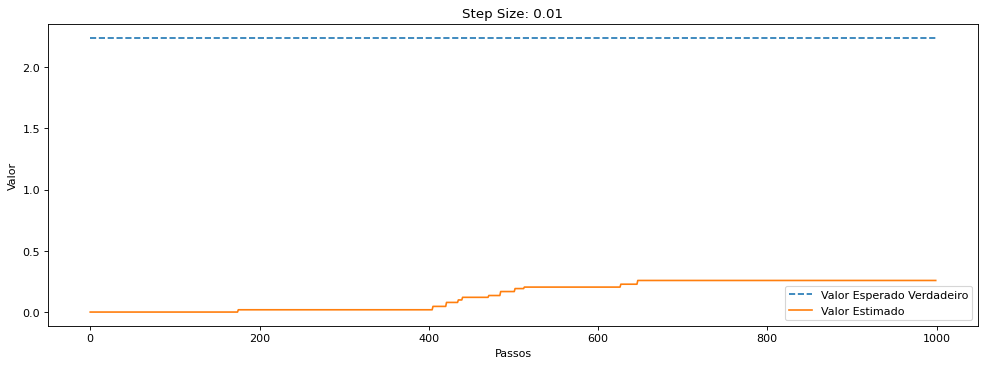

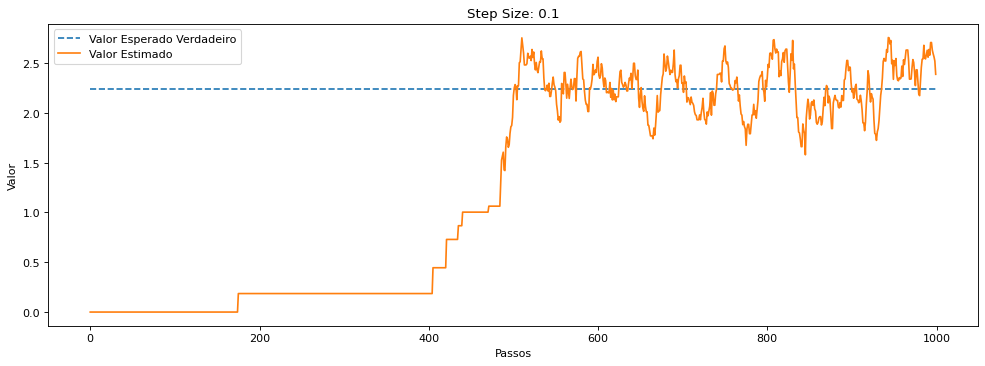

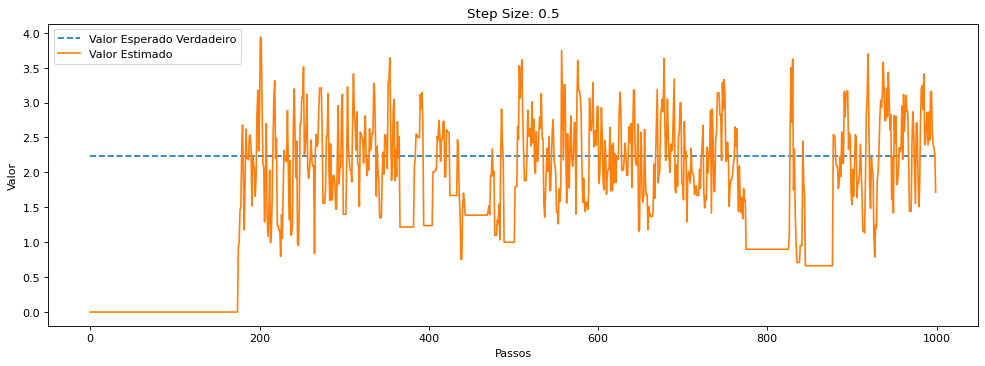

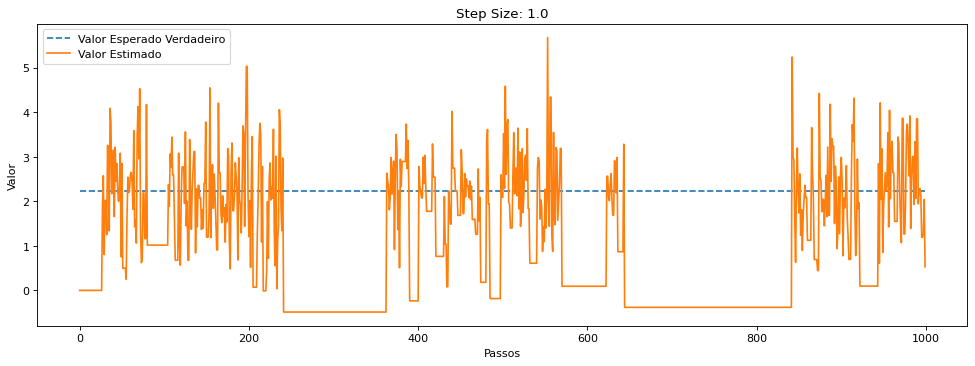

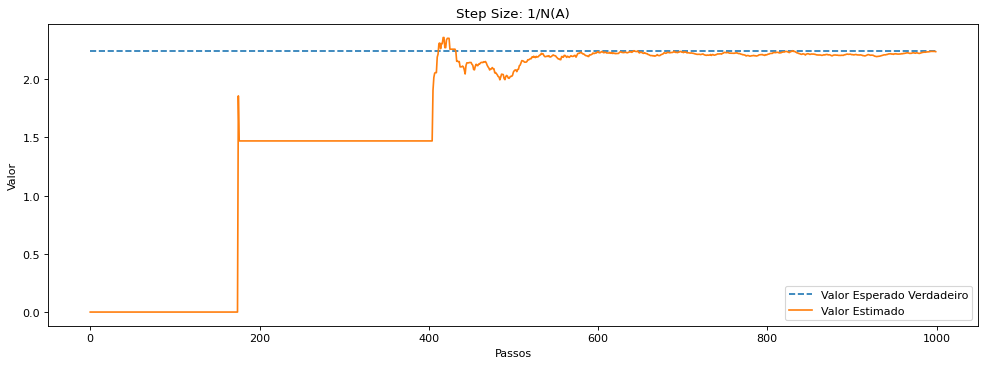

In [212]:
largest = 0
num_steps = 1000
for step_size in step_sizes:
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    largest = np.argmax(true_values[step_size])
    plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
    plt.title("Step Size: {}".format(step_size))
    plt.plot(np.array(q_values[step_size])[:, largest])
    plt.legend(["Valor Esperado Verdadeiro", "Valor Estimado"])
    plt.xlabel("Passos")
    plt.ylabel("Valor")
    plt.show()

Os gráficos ajudam a esclarecer as diferenças de desempenho entre os vários step-sizes. Um tamanho de etapa de 0.01 faz atualizações tão pequenas que a estimativa de valor do agente da melhor ação não chega perto do valor real. 

Tamanhos de passo de 0.5 e 1.0 chegam perto do valor verdadeiro rapidamente, mas são muito suscetíveis aos efeitos da aleatoriedades das recompensas. As atualizações corrigem muito em relação às recompensas recentes e, portanto, oscilam em torno do valor verdadeiro. Isso significa que, quanto mais o tempo passa, a ação que aciona o melhor braço pode parecer pior do que realmente é. Um tamanho de passo de 0.1 é atualizado com bastante rapidez para o valor verdadeiro e não oscila tanto em torno dos valores verdadeiros quanto 0,5 e 1,0. Este é um dos motivos pelos quais o 0.1 tem um bom desempenho. Finalmente, vemos por que 1/N(A) foi tão bem. No início, enquanto o step-size ainda é razoavelmente alto, ele se move rapidamente para o valor esperado verdadeiro, mas à medida que é acionado mais, o step-size é reduzido, o que o torna menos suscetível à aleatoriedade das recompensas.

Isso significa que 1/N(A) é sempre o melhor cenário? Quando não seria? Uma possível configuração em que esta abordagem não seria tão eficaz são em problemas não-estacionários. Não-estacionariedade significa que o ambiente pode mudar com o tempo. Isso pode se manifestar como uma mudança repentina nas condições do ambiente.

Vamos analisar agora como uma mudança repentina nas distribuições de recompensa afeta um tamanho de passo como 1/N(A). Desta vez, executaremos o ambiente em 2000 passos e, após 1000 etapas, alteraremos aleatoriamente o valor esperado de todos os braços. Comparamos dois agentes, ambos usando épsilon-greedy com epsilon = 0.1. Um usa um tamanho de passo constante de 0.1, o outro um tamanho de passo de 1/N(A).

100%|██████████| 200/200 [00:13<00:00, 14.86it/s]


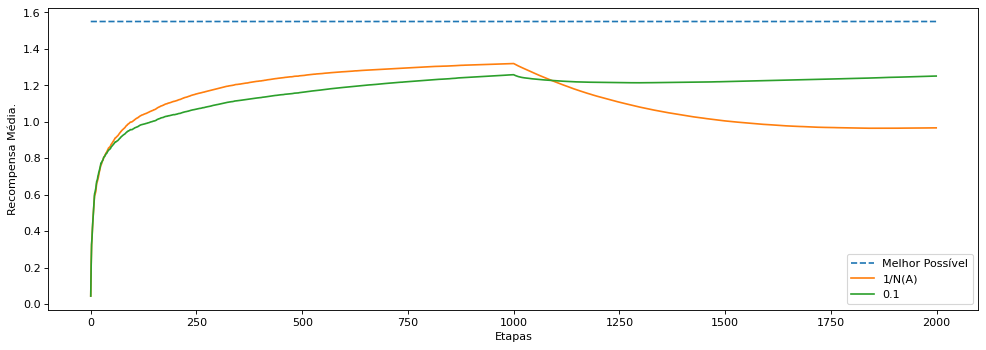

In [213]:
epsilon = 0.1
num_steps = 2000
num_runs = 200
step_size = 0.1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentConstantStepsize]:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}
        np.random.seed(run)
        
        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        scores = [0]
        averages = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if i == 1000:
                rl_glue.environment.arms = np.random.randn(10)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Melhor Possível", "1/N(A)", "0.1"])
plt.xlabel("Etapas")
plt.ylabel("Recompensa Média.")
plt.show()

Agora, o agente com um tamanho de etapa de 1/N(A) teve um desempenho melhor no início, mas teve um desempenho pior quando o ambiente mudou! O que aconteceu?

Quando atualizamos as condições de recompensa (não-estacionariedade) os novos valores são ainda são divididos pelo N(A) anterior. Mas note que agora as recompensas mudaram, significando que a ação ótima também pode ter sido alterada.

Entretanto, o agente com step-size 0.1 sempre será atualizado em 1/10 da direção do erro. Isso significa que, em média, serão necessários somente dez passos para atualizar seu valor para a média da amostra.